In [16]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler      # 预处理
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

import matplotlib as mpl
import matplotlib.pyplot as plt

import time

##### 设置字符集，防止中文乱码

In [2]:
mpl.rcParams['font.sans-serif']=[u'simHei']
mpl.rcParams['axes.unicode_minus']=False

##### 1、加载数据
—— 没有混合类型的时候可以通过 low_memory=F 调用更多内存，加快效率）

In [3]:
path1='datas/household_power_consumption_1000.txt'
df = pd.read_csv(path1, sep=';', low_memory=False)    # 从txt文件中加载数据

In [4]:
df.head() # 获取前五行数据查看查看。columns分别为日期、时间、有功功率、无功功率、电压、电流、厨房用电功率、洗衣服用电功率、热水器用电功率

Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0

##### 2、数据处理 过滤异常数据

In [5]:
new_df = df.replace('?', np.nan)  # 将 ? 替换为Nan
datas = new_df.dropna(how = 'any') 

###### 创建一个时间函数格式化字符串
—— time.strptime(str,format) 转换时间格式 

    format：%d/%m/%Y %H:%M:%S 

    返回struct_time元组，通过tm结构来获得日期和时间：
    tm_sec / tm_min / tm_hour 秒分时int类型

—— str1.join(seq) 用str1来连接 字符串序列 / 列表 / 元组 / 字典

    str = "-";
    seq = ("a", "b", "c"); # 字符串序列
    print str.join( seq );   # 输出：a-b-c

In [6]:
def Date_format(dt):
    t = time.strptime(' '.join(dt), '%d/%m/%Y %H:%M:%S')   # 通过空格来连接字符，将字符串形式的时间转换为标准的 日月年，时分秒 格式
                                                            # 通过这种方式，将每一个时间符号拆开
    return (t.tm_year, t.tm_mon, t.tm_mday, t.tm_hour, t.tm_min, t.tm_sec)   # 返回 年月日，时分秒 格式 的时间元祖，保证不同时间单位分开显示

##### 3、获取 样本X-时间 和 标签Y-功率变量

In [7]:
X = datas.iloc[:,0:2]   # 获取第0、1列的数据
print(X.head(2))
X = X.apply(lambda x: pd.Series(data = Date_format(x)), axis=1)   # 未定义columns

print()
print(X.head(2))   # 从这里可以看出，时间元祖被拆分成了矩阵

         Date      Time
0  16/12/2006  17:24:00
1  16/12/2006  17:25:00

      0   1   2   3   4  5
0  2006  12  16  17  24  0
1  2006  12  16  17  25  0


In [8]:
Y = datas['Global_active_power']

##### 4、数据分割
—— train_test_split(X,Y,test_size,random_state) 

    X是训练集，Y是测试集，X_train是训练集中的特征数据，Y_train是训练集中的结果数据。
    X,Y可以是lists, numpy arrays, scipy-sparse matrices or pandas dataframes.
    返回的类型和传入的X,Y类型保持一致。在后续的操作中，list、DadaFrame、Series都不会影响，columns是什么也不会构成影响
    test_size 或 train_size：测试集合的数据占比。它是一个(0,1)之间的float类型的值
    random_state: 随机数种子

In [9]:
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [10]:
print(X_train.shape)   # 训练集中，有800条数据，6个维度
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(800, 6)
(200, 6)
(800,)
(200,)


##### 5、数据预处理 - 标准化训练
—— StandardScaler() 将数据转换为均值μ为0 标准差σ^2为1的数据集(数据映射)

    with_mean：在进行数据转换的过程中，是否将数据转换为均值为0的数据(默认为True，表示是)
    with_std：在进行数据转换的过程中，是否将数据转换为标准差为1的数据(默认为True，表示是)

-》如果一个API名字有fit，那么就有模型训练的含义。简单来说，就是求得训练集X的均值、方差、最大值、最小值

-》如果一个API名字中有transform， 那么就表示对数据具有转换的含义操作。简单来说，就是在Fit的基础上，通过找中心和缩放等，进行标准化、降维、归一化等操作

-》如果一个API名字中有predict，那么就表示进行数据预测，会有一个预测结果输出

    在训练集上调用fit_transform()时，可以得到其均值μ和方差σ^2，即我们已经找到了转换规则，然后我们把这个规则用在训练集上。同样，我们直接将其运用到测试集上（甚至交叉验证集）。所以在测试集上的处理，我们只需要标准化数据而不需要再次拟合数据

In [11]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)  # 训练并转换 ，即先拟合数据，然后将其转化为标准形式
X_test = ss.transform(X_test)  # 仅对特征数据做标准化转换

# X_train = StandardScaler().fit_transform(X_train) 上面两步实际上是这样的

In [12]:
pd.DataFrame(X_train).describe().T   # 最主要的就是std中的变化

count          mean       std       min       25%       50%       75%  \
0  800.0  0.000000e+00  0.000000  0.000000  0.000000  0.000000  0.000000   
1  800.0  0.000000e+00  0.000000  0.000000  0.000000  0.000000  0.000000   
2  800.0  2.445821e-15  1.000626 -1.221561 -1.221561  0.818625  0.818625   
3  800.0 -8.604228e-17  1.000626 -1.333814 -0.837742 -0.341670  1.022529   
4  800.0  8.104628e-17  1.000626 -1.722545 -0.853268  0.016009  0.885286   
5  800.0  0.000000e+00  0.000000  0.000000  0.000000  0.000000  0.000000   

        max  
0  0.000000  
1  0.000000  
2  0.818625  
3  1.518601  
4  1.696611  
5  0.000000

##### 6、模型训练 + 预测 + 评估
—— LinearRegression() 线性回归模型

    fit_intercept: 训练的模型是否包含截距，默认为为True，表示包含
    coef_ ：模型训练好后的参数矩阵，即theta们的值 ；注意还有一个下划线
    intercept_: 截距值

—— .score(X,Y) 计算准确率  R^2

In [23]:
# 模型训练
# lr = LinearRegression()   # 得到模型 lr，该模型求最优线性回归
lr = SGDRegressor(learning_rate='constant')
lr.fit(X_train, Y_train) # 训练模型，拟合线性回归模型，获得X与Y之间的关系模型。lr可以理解为训练完成的模型，再用这个模型去预测、评估
# lr = LinearRegression().fit(X_train, Y_train) 上面两步实际上是这样的，lr就是标准化后的模型

# 预测结果
y_predict = lr.predict(X_test)   # 训练好的模型形成了一个目标函数，用该目标函数去预测测试值

# 模型评估
print("训练集准确率R**2:",lr.score(X_train, Y_train))   # 获取训练集的准确率
print("测试集准确率R**2:",lr.score(X_test, Y_test))    # 获取测试集的准确率
MSE = np.average((y_predict-Y_test)**2)   # 看预测结果与实际结果的MSE差值
print("MSE:",MSE)

训练集准确率R**2: 0.231659610244
测试集准确率R**2: 0.128847229601
MSE: 1.34994931642


##### 模型的部署，即保存模型
机器学习的部署方法：方法一，将模型进行输出；方法二，将预测结果输出

—— .dump() 保存模型

—— .load() 加载模型

In [14]:
from sklearn.externals import joblib

joblib.dump(ss, "data_ss.model") ## 保存标准化模型
joblib.dump(lr, "data_lr.model") ## 保存模型

ss = joblib.load("data_ss.model") ## 加载标准化模型
lr = joblib.load("data_lr.model") ## 加载模型

##### 使用部署好的模型进行预测

In [15]:
data1 = [[2006, 12, 17, 12, 25, 0]]
data1 = ss.transform(data1)   # 标准化时间样本
print(data1)

lr.predict(data1)   # 输出预测值

[[ 0.          0.          0.81862454  0.15440249 -0.27374978  0.        ]]


array([1.16996393])

##### 6、预测值和实际值画图比较

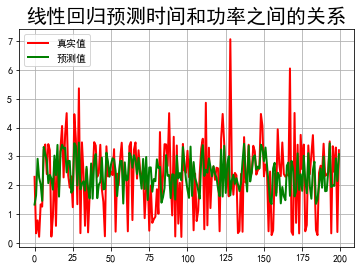

In [16]:
plt.figure(facecolor='w')   # 建一个画布，facecolor是背景色

t=np.arange(len(X_test))   # 用测试值范围（时间坐标）做x坐标
plt.plot(t, Y_test, 'r-', linewidth=2, label='真实值')
plt.plot(t, y_predict, 'g-', linewidth=2, label='预测值')

plt.legend(loc = 'upper left')  # 设置图例的位置
plt.title("线性回归预测时间和功率之间的关系", fontsize=20)
plt.grid()   # 加网格

plt.show()

# 功率和电流之间的关系

电流预测准确率:  0.9920420609708968
电流参数: [5.07744316 0.07191391]


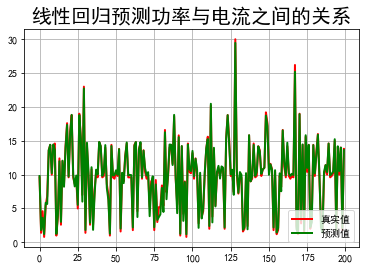

In [17]:
X2 = datas.iloc[:,2:4]
Y2 = datas.iloc[:,5]

# 1、数据分割
X2_train,X2_test,Y2_train,Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=0)

# 2、数据标准化（归一化）
scaler2 = StandardScaler()
X2_train = scaler2.fit_transform(X2_train) # 训练并转换
X2_test = scaler2.transform(X2_test) ## 直接使用在模型构建数据上进行一个数据标准化操作 

# 3、模型训练
lr2 = LinearRegression()
lr2.fit(X2_train, Y2_train)

# 4、结果预测
Y2_predict = lr2.predict(X2_test)

# 5、模型评估
print("电流预测准确率: ", lr2.score(X2_test,Y2_test))
print("电流参数:", lr2.coef_)

# 6、绘制图表——电流关系
t=np.arange(len(X2_test))   # 把X2_test数值压缩在x坐标上，方便查看 

plt.figure(facecolor='w')
plt.plot(t, Y2_test, 'r-', linewidth=2, label='真实值')   # 红线
plt.plot(t, Y2_predict, 'g-', linewidth=2, label='预测值')   # 绿线
plt.legend(loc = 'lower right')
plt.title(u"线性回归预测功率与电流之间的关系", fontsize=20)
plt.grid(b=True)
plt.show()